# 고객 대출등급 분류 해커톤

In [47]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


pip install missingno

In [48]:
import pandas as pd
import numpy as np

In [193]:
# 데이터셋 로드
raw_train = pd.read_csv('./data/train.csv')
raw_test = pd.read_csv('./data/test.csv')
print(raw_train.shape, raw_test.shape)

# 나중에 원핫인코딩 하기 위해 하나로 합침.
raw_data = pd.concat([raw_train, raw_test])

(96294, 15) (64197, 14)


In [195]:
raw_data.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


<Axes: >

C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython

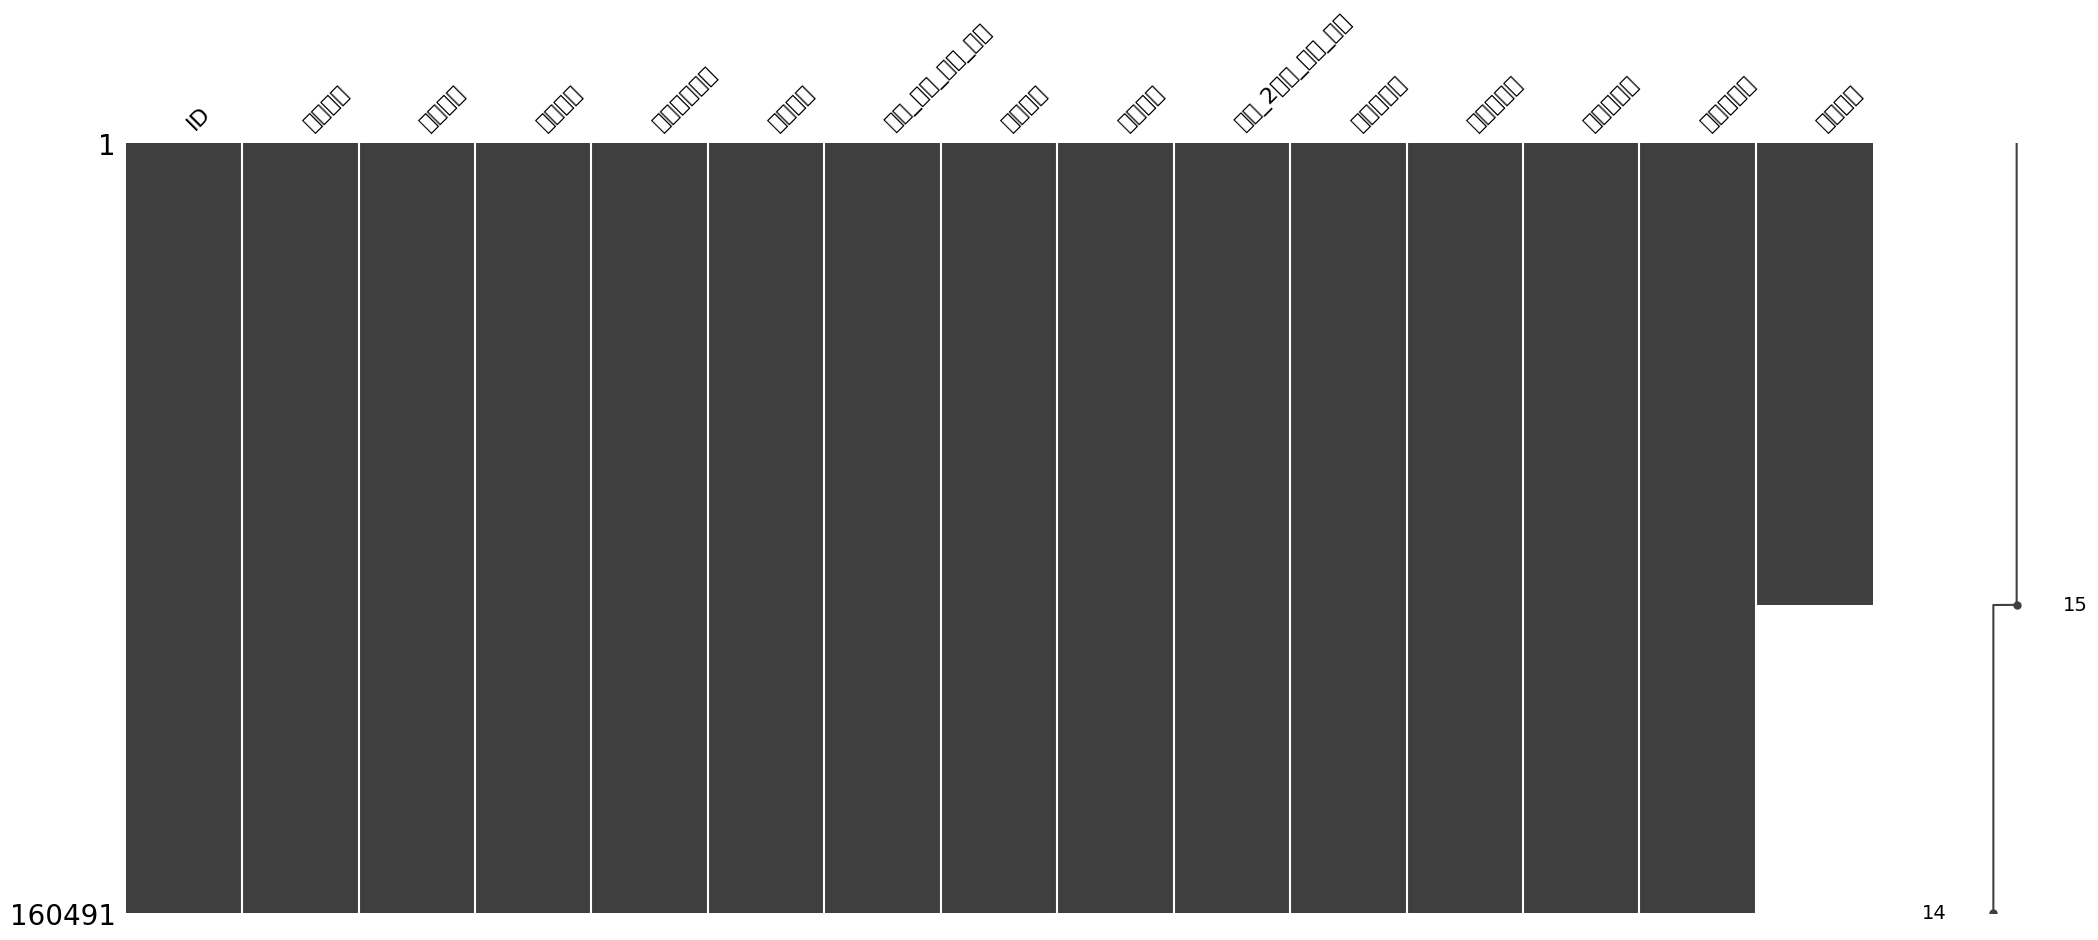

In [197]:
import missingno
missingno.matrix(raw_data)

'대출금액', 
'대출기간', 
'근로기간', 
'주택소유상태', 
'연간소득', 
'부채_대비_소득_비율', 
'총계좌수',       
 '대출목적',
 '최근_2년간_연체_횟수',
 '총상환원금',
 '총상환이자',
 '총연체금액',
 '연체계좌수',
 '대출등급'

# 범주형 데이터
- 대출기간 : [' 36 months', ' 60 months']
- 근로기간 : ['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years','2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year','10+years', '<1 year', '3', '1 years']
- 주택소유상태 : ['RENT', 'MORTGAGE', 'OWN', 'ANY']
- 대출목적 : ['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',  '기타', '이사', '주택', '재생 에너지'
- 연체계좌수 : [0., 1., 2., 4.]
']]

# 연속형 데이터
- 대출금액
- 연간소득
- 부채_대비_소득_비율
- 총계좌수
- 최근_2년간_연체_횟수
- 총상환원금
- 총상환이자
- 총연체금액

## y값
- 대출등급 : ['C', 'B', 'A', 'D', 'F', 'G', 'E']

# feature engineering
- 대출기간 숫자로
- 총계좌수 대비 연체계좌수 비율
- 대출금액 대비 총연체금액 비율
- 대출금액 대비 총상환원금 + 총상환이자 비율
- 근로기간 범주형으로
- 최근_2년간_연체_횟수 범주형으로
- get_dummies() : 근로기간 / 주택소유상태 / 대출목적

In [198]:
raw_data['대출기간'].value_counts()

대출기간
 36 months    107708
 60 months     52783
Name: count, dtype: int64

In [199]:
raw_data['근로기간'].unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [200]:
raw_data['주택소유상태'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

In [201]:
raw_data['대출금액'].unique()

array([12480000, 14400000, 12000000, ..., 38730000, 41190000, 41220000],
      dtype=int64)

In [202]:
raw_data['연간소득'].value_counts()

연간소득
72000000      6366
60000000      5439
78000000      4896
84000000      4565
90000000      4431
              ... 
87682800         1
40959360         1
105225600        1
64939200         1
1356000000       1
Name: count, Length: 11790, dtype: int64

In [203]:
raw_data['부채_대비_소득_비율']

0        18.90
1        22.33
2         8.60
3        15.09
4        25.39
         ...  
64192    22.08
64193    12.06
64194    28.80
64195    25.44
64196     9.07
Name: 부채_대비_소득_비율, Length: 160491, dtype: float64

In [204]:
raw_data['총계좌수']

0        15
1        21
2        14
3        15
4        19
         ..
64192    27
64193    26
64194    33
64195    41
64196    10
Name: 총계좌수, Length: 160491, dtype: int64

In [205]:
raw_data['대출목적'].unique()

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지', '결혼'], dtype=object)

In [206]:
raw_data['최근_2년간_연체_횟수'].value_counts()

최근_2년간_연체_횟수
0     127358
1      21782
2       6490
3       2398
4       1133
5        556
6        303
7        158
8        102
9         64
10        57
11        35
13        17
12        16
14        10
16         4
15         4
18         2
17         1
30         1
Name: count, dtype: int64

In [207]:
raw_data['대출등급'].unique()

array(['C', 'B', 'A', 'D', 'F', 'G', 'E', nan], dtype=object)

In [208]:
raw_data['연체계좌수'].unique()

array([0., 1., 2., 4., 3.])

In [209]:
raw_data['총상환이자']

0              0.0
1         234060.0
2         151944.0
3         153108.0
4         148956.0
           ...    
64192     763380.0
64193    1245252.0
64194      80880.0
64195     601872.0
64196      48960.0
Name: 총상환이자, Length: 160491, dtype: float64

C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


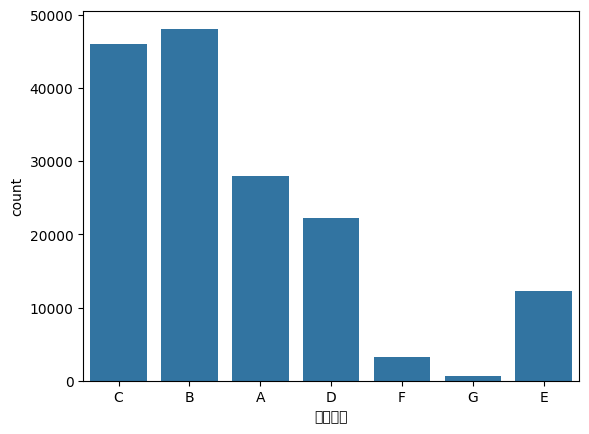

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='대출등급', data=raw_data)
plt.show()

# 전처리

In [211]:
raw_data['대출기간'].unique() # 3년, 5년 

array([' 36 months', ' 60 months'], dtype=object)

In [212]:
raw_data['근로기간'].unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [213]:
raw_data['주택소유상태'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

In [214]:
raw_data['대출목적'].unique() # 3년, 5년 

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지', '결혼'], dtype=object)

---


# feature engineering
1. **대출기간 숫자로**
2. 근로기간 범주형으로
3. 총계좌수 대비 연체계좌수 비율
4. 대출금액 대비 총연체금액 비율
5. 대출금액 대비 총상환원금 + 총상환이자 비율
6. 최근_2년간_연체_횟수 범주형으로
7. get_dummies() : 근로기간 / 주택소유상태 / 대출목적

In [261]:
df = raw_data.copy()
df

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,TEST_64192,30000000,36 months,3 years,MORTGAGE,78000000,22.08,27,부채 통합,2,1307532,763380.0,0.0,0.0,NaN
64193,TEST_64193,30000000,60 months,10+ years,MORTGAGE,109200000,12.06,26,부채 통합,0,960612,1245252.0,0.0,0.0,NaN
64194,TEST_64194,6120000,36 months,10+ years,RENT,39600000,28.80,33,부채 통합,0,131520,80880.0,0.0,0.0,NaN
64195,TEST_64195,11520000,36 months,10+ years,MORTGAGE,66000000,25.44,41,부채 통합,1,1339536,601872.0,0.0,0.0,NaN


In [262]:
import pandas as pd

df['대출기간'] = df['대출기간'].map({' 36 months': 3, ' 60 months': 5})

# 결과 확인
df['대출기간'].unique()

array([3, 5], dtype=int64)

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

# feature engineering
1. 대출기간 숫자로
2. **근로기간 범주형으로**
3. 총계좌수 대비 연체계좌수 비율
4. 대출금액 대비 총연체금액 비율
5. 대출금액 대비 총상환원금 + 총상환이자 비율
6. 최근_2년간_연체_횟수 범주형으로
7. get_dummies() : 근로기간 / 주택소유상태 / 대출목적

In [263]:
df['근로기간'].value_counts()

근로기간
10+ years    52522
2 years      14059
< 1 year     12917
3 years      12617
1 year       10484
5 years       9592
Unknown       9533
4 years       9250
8 years       8172
6 years       6353
7 years       6329
9 years       6289
10+years      1512
<1 year        629
3              138
1 years         95
Name: count, dtype: int64

In [264]:
import pandas as pd
import numpy as np

# 데이터프레임에서 '근로기간' 열 선택
df['근로기간'] = df['근로기간'].replace(['Unknown'], np.nan)

# '< 1 year'을 1으로 대체
df['근로기간'].replace('< 1', 1, inplace=True)
df['근로기간'].replace('< 1 year', 1, inplace=True)
df['근로기간'].replace('<1 year', 1, inplace=True)

# '10+ years' 또는 '10+years'를 10으로 대체
df['근로기간'].replace('10+', 10, inplace=True)
df['근로기간'].replace('10+years', 10, inplace=True)
df['근로기간'].replace('10+ years', 10, inplace=True)

# 결과 확인
print(df['근로기간'].unique())

['6 years' 10 '5 years' '8 years' nan '9 years' '2 years' '1 year'
 '3 years' '7 years' '4 years' 1 '3' '1 years']


In [265]:
# years 삭제하고 숫자로 표현
df['근로기간'] = pd.to_numeric(df['근로기간'].astype(str).str.replace(' years', '').str.extract('(\d+)', expand=False))
# 결과 확인
print(df['근로기간'].unique())

[ 6. 10.  5.  8. nan  9.  2.  1.  3.  7.  4.]


In [266]:
# Unknown 인 경우 연간 소득이 비슷한 사람의 median으로 결측치를 대체하기
# df[df['근로기간'] == 'Unknown']

df['근로기간'] = df.groupby('연간소득')['근로기간'].transform(lambda x: x.fillna(x.median()))
print(df['근로기간'].unique())

C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1

[ 6.  10.   5.   8.   3.   9.   2.   1.   7.   4.   nan  8.5  7.5  5.5
  3.5  4.5  1.5  6.5  2.5  9.5]


C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [267]:
df[(df['근로기간'] > 3) & (df['근로기간'] <= 6)]

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,3,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
2,TRAIN_00002,12000000,3,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
15,TRAIN_00015,8640000,3,4.0,RENT,92400000,20.40,17,의료,0,196980,88572.0,0.0,0.0,C
32,TRAIN_00032,21000000,5,5.0,MORTGAGE,60000000,13.32,17,부채 통합,0,530748,363000.0,0.0,0.0,B
34,TRAIN_00034,14550000,3,4.0,OWN,222000000,2.13,31,부채 통합,6,655620,320448.0,0.0,0.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64177,TEST_64177,7230000,3,5.0,RENT,62400000,23.68,31,이사,7,320544,171264.0,0.0,0.0,NaN
64181,TEST_64181,12000000,3,4.0,RENT,54000000,30.53,33,신용 카드,0,568404,209880.0,0.0,0.0,NaN
64185,TEST_64185,9600000,3,5.0,MORTGAGE,54000000,8.11,14,부채 통합,0,966660,219720.0,0.0,0.0,NaN
64186,TEST_64186,37230000,3,5.0,MORTGAGE,144000000,28.14,25,부채 통합,2,3289584,1918116.0,0.0,0.0,NaN


In [268]:
df.loc[ df['근로기간'] <= 3, '근로기간'] = 1
df.loc[(df['근로기간'] > 3) & (df['근로기간'] <= 6), '근로기간'] = 2
df.loc[(df['근로기간'] > 6) & (df['근로기간'] <= 9), '근로기간'] = 3
df.loc[ df['근로기간'] > 9, '근로기간'] = 4
df['근로기간'].unique()

array([ 2.,  4.,  3.,  1., nan])

In [269]:
df[df['근로기간'] == 2.5]

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급


In [270]:
df['근로기간'].value_counts()

근로기간
4.0    54238
1.0    52123
2.0    28918
3.0    23250
Name: count, dtype: int64

# feature engineering
1. 대출기간 숫자로
2. 근로기간 범주형으로
3. **총계좌수 대비 연체계좌수 비율**
4. 대출금액 대비 총연체금액 비율
5. 대출금액 대비 총상환원금 + 총상환이자 비율
6. 최근_2년간_연체_횟수 범주형으로
7. get_dummies() : 근로기간 / 주택소유상태 / 대출목적

In [271]:
df2 = df.copy()

In [272]:
df2['연체계좌수'].value_counts()

연체계좌수
0.0    159631
1.0       814
2.0        42
4.0         2
3.0         2
Name: count, dtype: int64

In [273]:
df2['연체계좌비율'] = df2['연체계좌수'] / df2['총계좌수']
df2['연체계좌비율'].value_counts()

연체계좌비율
0.000000    159631
0.045455        39
0.034483        35
0.033333        33
0.041667        33
             ...  
0.012346         1
0.013889         1
0.015625         1
0.010753         1
0.017544         1
Name: count, Length: 82, dtype: int64

# feature engineering
1. 대출기간 숫자로
2. 근로기간 범주형으로
3. 총계좌수 대비 연체계좌수 비율
4. **대출금액 대비 총연체금액 비율**
5. **대출금액 대비 총상환원금 + 총상환이자 비율**
6. 최근_2년간_연체_횟수 범주형으로
7. get_dummies() : 근로기간 / 주택소유상태 / 대출목적

In [274]:
df2['총연체비율'] = df2['총연체금액'] / df2['대출금액']
df2['총상환비율'] = (df2['총상환원금'] + df2['총상환이자']) / df2['대출금액']

In [275]:
df2.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,연체계좌비율,총연체비율,총상환비율
0,TRAIN_00000,12480000,3,2.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.0,0.0,0.000000
1,TRAIN_00001,14400000,5,4.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,0.0,0.0,0.042197
2,TRAIN_00002,12000000,3,2.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,0.0,0.0,0.090049
3,TRAIN_00003,14400000,3,3.0,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C,0.0,0.0,0.033259
4,TRAIN_00004,18000000,5,1.0,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B,0.0,0.0,0.020972


# feature engineering
1. 대출기간 숫자로
2. 근로기간 범주형으로
3. 총계좌수 대비 연체계좌수 비율
4. 대출금액 대비 총연체금액 비율
5. 대출금액 대비 총상환원금 + 총상환이자 비율
6. **최근_2년간_연체_횟수 범주형으로**
7. get_dummies() : 근로기간 / 주택소유상태 / 대출목적

In [276]:
df2['최근_2년간_연체_횟수'].value_counts()

최근_2년간_연체_횟수
0     127358
1      21782
2       6490
3       2398
4       1133
5        556
6        303
7        158
8        102
9         64
10        57
11        35
13        17
12        16
14        10
16         4
15         4
18         2
17         1
30         1
Name: count, dtype: int64

## 범주형으로 안바꿔도 될듯

# feature engineering
1. 대출기간 숫자로
2. 근로기간 범주형으로
3. 총계좌수 대비 연체계좌수 비율
4. 대출금액 대비 총연체금액 비율
5. 대출금액 대비 총상환원금 + 총상환이자 비율
6. 최근_2년간_연체_횟수 범주형으로
7. **get_dummies() : 근로기간 / 주택소유상태 / 대출목적**

# 불필요한 컬럼 삭제

In [277]:
drop_cols = ['총연체금액','총상환원금','총상환이자','연체계좌수','총계좌수']
df2 = df2.drop(drop_cols, axis=1)

# 원핫 인코딩
숫자형이 아닌 카테고리화된 feature는 get_dummies() 이용해 숫자로 변경

In [278]:
df = df2.copy()
# 전처리 완료 후 데이터 train과 test로 쪼갬
df_train = df.iloc[:96294,:]
df_test = df.iloc[96294:,:]

In [279]:
# '주택소유상태' 열에 대한 원-핫 인코딩
onehot_cols = ['근로기간', '주택소유상태', '대출목적']
df_train = pd.get_dummies(df_train, columns=onehot_cols)
df_test = pd.get_dummies(df_test, columns=onehot_cols)
df_train.head()

,ID,대출금액,대출기간,연간소득,부채_대비_소득_비율,최근_2년간_연체_횟수,대출등급,연체계좌비율,총연체비율,총상환비율,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TRAIN_00000,12480000,3,72000000,18.90,0,C,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
1,TRAIN_00001,14400000,5,130800000,22.33,0,B,0.0,0.0,0.042197,...,False,False,False,False,False,False,False,False,True,False
2,TRAIN_00002,12000000,3,96000000,8.60,0,A,0.0,0.0,0.090049,...,False,False,False,False,False,False,False,False,False,False
3,TRAIN_00003,14400000,3,132000000,15.09,0,C,0.0,0.0,0.033259,...,False,False,False,False,False,False,False,False,False,False
4,TRAIN_00004,18000000,5,71736000,25.39,0,B,0.0,0.0,0.020972,...,False,False,False,False,False,False,True,False,False,False


In [280]:
df_train['대출등급']

0        C
1        B
2        A
3        C
4        B
        ..
96289    C
96290    E
96291    A
96292    D
96293    C
Name: 대출등급, Length: 96294, dtype: object

In [281]:
df_test.head()

,ID,대출금액,대출기간,연간소득,부채_대비_소득_비율,최근_2년간_연체_횟수,대출등급,연체계좌비율,총연체비율,총상환비율,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TEST_00000,16800000,3,132000000,19.64,0,NaN,0.0,0.0,0.032220,...,False,False,False,False,False,False,False,False,True,False
1,TEST_00001,8400000,3,89971200,15.84,0,NaN,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
2,TEST_00002,17280000,3,150000000,8.41,0,NaN,0.0,0.0,0.119722,...,False,True,False,False,False,False,False,False,False,False
3,TEST_00003,14400000,3,66000000,13.72,1,NaN,0.0,0.0,0.066024,...,False,True,False,False,False,False,False,False,False,False
4,TEST_00004,27600000,3,55200000,30.50,0,NaN,0.0,0.0,0.067569,...,False,True,False,False,False,False,False,False,False,False


In [282]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred)
    
    print('-> confusion matrix')
    print(confusion)
    print('====')
    
    print('accuracy: {0:.4f}, precision: {1:.4f}'.format(acc, pre))
    print('recall: {0:.4f}, F1: {1:.4f}, auc:{2:.4f}'.format(re, f1, auc))

# 데이터 분리

In [283]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['대출등급'])

X = df_train.drop(['대출등급', 'ID'], axis=1)
X.shape, y.shape

((96294, 28), (96294,))

# 테스트 데이터

In [284]:
df_test.head()

,ID,대출금액,대출기간,연간소득,부채_대비_소득_비율,최근_2년간_연체_횟수,대출등급,연체계좌비율,총연체비율,총상환비율,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TEST_00000,16800000,3,132000000,19.64,0,NaN,0.0,0.0,0.032220,...,False,False,False,False,False,False,False,False,True,False
1,TEST_00001,8400000,3,89971200,15.84,0,NaN,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
2,TEST_00002,17280000,3,150000000,8.41,0,NaN,0.0,0.0,0.119722,...,False,True,False,False,False,False,False,False,False,False
3,TEST_00003,14400000,3,66000000,13.72,1,NaN,0.0,0.0,0.066024,...,False,True,False,False,False,False,False,False,False,False
4,TEST_00004,27600000,3,55200000,30.50,0,NaN,0.0,0.0,0.067569,...,False,True,False,False,False,False,False,False,False,False


# 원핫인코딩 문제 때문에 처음부터 다시

In [4]:
raw_train = pd.read_csv('./data/train.csv')
raw_test = pd.read_csv('./data/test.csv')
print(raw_train.shape, raw_test.shape)

(96294, 15) (64197, 14)


In [5]:
raw_data = pd.concat([raw_train, raw_test])
raw_data.shape

(160491, 15)

In [6]:
import pandas as pd
import numpy as np
import pandas as pd

raw_data['대출기간'] = raw_data['대출기간'].map({' 36 months': 3, ' 60 months': 5})

# 데이터프레임에서 '근로기간' 열 선택
raw_data['근로기간'] = raw_data['근로기간'].replace(['Unknown'], np.nan)

# '< 1 year'을 0으로 대체
raw_data['근로기간'].replace('< 1', 0, inplace=True)
raw_data['근로기간'].replace('< 1 year', 0, inplace=True)
raw_data['근로기간'].replace('<1 year', 0, inplace=True)

# '10+ years' 또는 '10+years'를 10으로 대체
raw_data['근로기간'].replace('10+', 10, inplace=True)
raw_data['근로기간'].replace('10+years', 10, inplace=True)
raw_data['근로기간'].replace('10+ years', 10, inplace=True)

# years 삭제하고 숫자로 표현
raw_data['근로기간'] = pd.to_numeric(raw_data['근로기간'].astype(str).str.replace(' years', '').str.extract('(\d+)', expand=False).fillna(0))

# '주택소유상태' 열에 대한 원-핫 인코딩
raw_data = pd.get_dummies(raw_data, columns=['주택소유상태'], prefix='주택소유상태')
raw_data.head()

# '대출목적' 열에 대한 원-핫 인코딩
raw_data = pd.get_dummies(raw_data, columns=['대출목적'], prefix='대출목적')
raw_data.head()

,ID,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TRAIN_00000,12480000,3,6,72000000,18.90,15,0,0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,TRAIN_00001,14400000,5,10,130800000,22.33,21,0,373572,234060.0,...,False,False,False,False,False,False,False,False,True,False
2,TRAIN_00002,12000000,3,5,96000000,8.60,14,0,928644,151944.0,...,False,False,False,False,False,False,False,False,False,False
3,TRAIN_00003,14400000,3,8,132000000,15.09,15,0,325824,153108.0,...,False,False,False,False,False,False,False,False,False,False
4,TRAIN_00004,18000000,5,0,71736000,25.39,19,0,228540,148956.0,...,False,False,False,False,False,False,True,False,False,False


### train, test 다시 쪼개기

In [7]:
raw_data.columns

Index(['ID', '대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수',
       '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급',
       '주택소유상태_ANY', '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_결혼',
       '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료',
       '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택',
       '대출목적_주택 개선', '대출목적_휴가'],
      dtype='object')

In [8]:
onehot_train = raw_data.iloc[:96294,:]
onehot_valid = raw_data.iloc[96294:,:]
print(onehot_train.shape, onehot_valid.shape)

(96294, 30) (64197, 30)


### onehot_train 데이터로 모델학습

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(onehot_train['대출등급'])

X = onehot_train.drop(['대출등급', 'ID'], axis=1)
X.shape, y.shape

((96294, 28), (96294,))

In [10]:
X.columns

Index(['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수',
       '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '주택소유상태_ANY', '주택소유상태_MORTGAGE',
       '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_결혼', '대출목적_기타', '대출목적_부채 통합',
       '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차',
       '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴가'],
      dtype='object')

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

### lightGBM

In [13]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

# Assuming you have defined X_train, X_test, y_train, y_test

lgbm = LGBMClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
    # Add other hyperparameters as needed
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1453
[LightGBM] [Info] Number of data points in the train set: 44936, number of used features: 26
[LightGBM] [Info] Start training from score -1.747788
[LightGBM] [Info] Start training from score -1.206483
[LightGBM] [Info] Start training from score -1.248710
[LightGBM] [Info] Start training from score -1.975542
[LightGBM] [Info] Start training from score -2.572096
[LightGBM] [Info] Start training from score -3.897355
[LightGBM] [Info] Start training from score -5.434880
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [16]:
# Access the best estimator
best_lgbm_model = grid_search.best_estimator_

# Now you can use the best model for predictions
accuracy = accuracy_score(y_test, best_lgbm_model.predict(X_test))
print('Accuracy:', accuracy)

Accuracy: 0.8592543874831251


In [17]:
predictions = best_lgbm_model.predict(X_test)
decoded_predictions = label_encoder.inverse_transform(predictions.astype(int))
decoded_predictions

array(['B', 'D', 'C', ..., 'D', 'B', 'C'], dtype=object)

In [18]:
onehot_valid.columns

Index(['ID', '대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수',
       '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급',
       '주택소유상태_ANY', '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_결혼',
       '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료',
       '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택',
       '대출목적_주택 개선', '대출목적_휴가'],
      dtype='object')

In [20]:
final_data = onehot_valid.drop(['대출등급', 'ID'], axis=1)
final_data.shape

(64197, 28)

In [21]:
predictions = best_lgbm_model.predict(final_data)
decoded_predictions = label_encoder.inverse_transform(predictions.astype(int))
decoded_predictions

array(['B', 'B', 'A', ..., 'D', 'C', 'A'], dtype=object)

In [23]:
onehot_valid['ID']

0        TEST_00000
1        TEST_00001
2        TEST_00002
3        TEST_00003
4        TEST_00004
            ...    
64192    TEST_64192
64193    TEST_64193
64194    TEST_64194
64195    TEST_64195
64196    TEST_64196
Name: ID, Length: 64197, dtype: object

In [26]:
result = pd.DataFrame()
result['ID'] = onehot_valid['ID']
result['대출등급'] = decoded_predictions


,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C


In [29]:
result.to_csv('result_submission.csv', index=False, encoding='utf-8')

In [31]:
sample_submission = pd.read_csv('result_submission.csv')
sample_submission.head()

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C


# 하나의 코드로 정리하면

In [1]:
import pandas as pd
import numpy as np
import pandas as pd

# 데이터셋 로드
raw_train = pd.read_csv('./data/train.csv')
raw_test = pd.read_csv('./data/test.csv')
print(raw_train.shape, raw_test.shape)

# 나중에 원핫인코딩 하기 위해 하나로 합침.
raw_data = pd.concat([raw_train, raw_test])

# 데이터 전처리 '대출기간'
raw_data['대출기간'] = raw_data['대출기간'].map({' 36 months': 3, ' 60 months': 5})
# 데이터 전처리 '근로기간'
raw_data['근로기간'] = raw_data['근로기간'].replace(['Unknown'], np.nan) # 데이터프레임에서 '근로기간' 열 선택
raw_data['근로기간'].replace('< 1', 0, inplace=True)
raw_data['근로기간'].replace('< 1 year', 0, inplace=True)
raw_data['근로기간'].replace('<1 year', 0, inplace=True)
raw_data['근로기간'].replace('10+', 10, inplace=True)
raw_data['근로기간'].replace('10+years', 10, inplace=True)
raw_data['근로기간'].replace('10+ years', 10, inplace=True)
# years 삭제하고 숫자로 표현
raw_data['근로기간'] = pd.to_numeric(raw_data['근로기간'].astype(str).str.replace(' years', '').str.extract('(\d+)', expand=False).fillna(0))
# 데이터 전처리 '주택소유상태' 열에 대한 원-핫 인코딩
raw_data = pd.get_dummies(raw_data, columns=['주택소유상태'], prefix='주택소유상태')
# '대출목적' 열에 대한 원-핫 인코딩
raw_data = pd.get_dummies(raw_data, columns=['대출목적'], prefix='대출목적')

# 전처리 완료 후 데이터 train과 test로 쪼갬
onehot_train = raw_data.iloc[:96294,:]
onehot_valid = raw_data.iloc[96294:,:]

# y 레이블은 카테고리여서 인코딩 필요
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(onehot_train['대출등급'])
X = onehot_train.drop(['대출등급', 'ID'], axis=1)

# train 데이터와 test 데이터로 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

# 모델 선언 light GBM model
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
    # Add other hyperparameters as needed
}

# 최적의 파라미터 구하기
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

# Access the best estimator
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix
best_lgbm_model = grid_search.best_estimator_
accuracy = accuracy_score(y_test, best_lgbm_model.predict(X_test))
print('test Accuracy:', accuracy)

# 모델로 예측
final_data = onehot_valid.drop(['대출등급', 'ID'], axis=1)
predictions = best_lgbm_model.predict(final_data)
decoded_predictions = label_encoder.inverse_transform(predictions.astype(int))

# 최종결과 csv로 저장
result = pd.DataFrame()
result['ID'] = onehot_valid['ID']
result['대출등급'] = decoded_predictions
result.to_csv('result_submission.csv', index=False, encoding='utf-8')

(96294, 15) (64197, 14)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1453
[LightGBM] [Info] Number of data points in the train set: 44936, number of used features: 26
[LightGBM] [Info] Start training from score -1.747788
[LightGBM] [Info] Start training from score -1.206483
[LightGBM] [Info] Start training from score -1.248710
[LightGBM] [Info] Start training from score -1.975542
[LightGBM] [Info] Start training from score -2.572096
[LightGBM] [Info] Start training from score -3.897355
[LightGBM] [Info] Start training from score -5.434880
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003120 seconds.
You can set `force_col_wise=true` to remove t

NameError: name 'accuracy_score' is not defined

In [2]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix

# Access the best estimator
best_lgbm_model = grid_search.best_estimator_
accuracy = accuracy_score(y_test, best_lgbm_model.predict(X_test))
print('test Accuracy:', accuracy)

test Accuracy: 0.8592543874831251


# 2024-01-18

---

In [3]:
raw_data = pd.read_csv('./data/train.csv')
raw_data.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [ ]:
pip install scikit-learn

In [ ]:
pip install 

# 모델 XGBoost 학습시키기

In [3]:
import pandas as pd
import numpy as np
import pandas as pd

# 데이터셋 로드
raw_train = pd.read_csv('./data/train.csv')
raw_test = pd.read_csv('./data/test.csv')
print(raw_train.shape, raw_test.shape)

# 나중에 원핫인코딩 하기 위해 하나로 합침.
raw_data = pd.concat([raw_train, raw_test])

# 데이터 전처리 '대출기간'
raw_data['대출기간'] = raw_data['대출기간'].map({' 36 months': 3, ' 60 months': 5})
# 데이터 전처리 '근로기간'
raw_data['근로기간'] = raw_data['근로기간'].replace(['Unknown'], np.nan) # 데이터프레임에서 '근로기간' 열 선택
raw_data['근로기간'].replace('< 1', 0, inplace=True)
raw_data['근로기간'].replace('< 1 year', 0, inplace=True)
raw_data['근로기간'].replace('<1 year', 0, inplace=True)
raw_data['근로기간'].replace('10+', 10, inplace=True)
raw_data['근로기간'].replace('10+years', 10, inplace=True)
raw_data['근로기간'].replace('10+ years', 10, inplace=True)
# years 삭제하고 숫자로 표현
raw_data['근로기간'] = pd.to_numeric(raw_data['근로기간'].astype(str).str.replace(' years', '').str.extract('(\d+)', expand=False).fillna(0))
# 데이터 전처리 '주택소유상태' 열에 대한 원-핫 인코딩
raw_data = pd.get_dummies(raw_data, columns=['주택소유상태'], prefix='주택소유상태')
# '대출목적' 열에 대한 원-핫 인코딩
raw_data = pd.get_dummies(raw_data, columns=['대출목적'], prefix='대출목적')

# 전처리 완료 후 데이터 train과 test로 쪼갬
onehot_train = raw_data.iloc[:96294,:]
onehot_valid = raw_data.iloc[96294:,:]

# y 레이블은 카테고리여서 인코딩 필요
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(onehot_train['대출등급'])
X = onehot_train.drop(['대출등급', 'ID'], axis=1)

# train 데이터와 test 데이터로 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)


(96294, 15) (64197, 14)


# 1단계 grid search

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

learning_rate = [0.01, 0.05, 0.06, 0.1]
n_estimators = [10, 50, 60, 75, 85, 100]

param_grid = {
    'learning_rate': learning_rate, 
    'n_estimators': n_estimators
}

grid_search=GridSearchCV(
    estimator = XGBClassifier(random_state=1, eval_metric='logloss'), 
    param_grid = param_grid, 
    verbose=True, 
    cv=3, 
    scoring = "accuracy", 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
0.819850162925931
{'learning_rate': 0.1, 'n_estimators': 100}


# 2단계

In [7]:
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6, 7]

param_grid = {
    'max_depth': max_depth, 
    'min_child_weight': min_child_weight
}

grid_search=GridSearchCV(
    estimator = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=1, eval_metric='logloss'), 
    param_grid = param_grid, 
    verbose=True, 
    cv=5, 
    scoring = "accuracy", 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
0.8518062458274608
{'max_depth': 10, 'min_child_weight': 1}


# 3단계

In [9]:
gamma =  [i*0.1 for i in range(0,5)]
subsample = [0.6, 0.65, 0.7, 0.75]
colsample_bytree = [0.6, 0.65, 0.7]
reg_alpha = [1e-5, 1e-2, 0.1, 1]

param_grid = {
    'gamma': gamma,
    'subsample':subsample,
    'colsample_bytree':colsample_bytree,
    'reg_alpha': reg_alpha
}

grid_search=GridSearchCV(
    estimator = XGBClassifier(
        learning_rate=0.17, 
        n_estimators=10, 
        max_depth=10, 
        min_child_weight=1,
        random_state=1,
        eval_metric='logloss'
    ), 
    param_grid = param_grid, 
    verbose=True, 
    cv=3, 
    scoring = "accuracy", 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
0.8100141145152073
{'colsample_bytree': 0.7, 'gamma': 0.30000000000000004, 'reg_alpha': 0.01, 'subsample': 0.75}


# 마무리

In [11]:
# Access the best estimator
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix

best_XGBoost_model = grid_search.best_estimator_
accuracy = accuracy_score(y_test, best_XGBoost_model.predict(X_test))
print('test Accuracy:', accuracy)

test Accuracy: 0.824119907231126


In [12]:
# 모델로 예측
final_data = onehot_valid.drop(['대출등급', 'ID'], axis=1)
predictions = best_XGBoost_model.predict(final_data)
decoded_predictions = label_encoder.inverse_transform(predictions.astype(int))

# 최종결과 csv로 저장
result = pd.DataFrame()
result['ID'] = onehot_valid['ID']
result['대출등급'] = decoded_predictions
result.to_csv('result_best_XGBoost_model_submission.csv', index=False, encoding='utf-8')

# 정확도 더 떨어짐... test Accuracy: 0.824119907231126

In [16]:
pip install lightgbm

  Using cached lightgbm-4.3.0-py3-none-win_amd64.whl.metadata (19 kB)
Using cached lightgbm-4.3.0-py3-none-win_amd64.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


# 중요한 Feature만 추출

In [18]:
import numpy as np # 각 모델에서 내부적으로 관련 라이브러리 사용 가능
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier             # 1. K-Nearest Neighbor(KNN)
from sklearn.linear_model import LogisticRegression            # 2. Logistic Regression
from sklearn.svm import SVC                                    # 3. SVC
from sklearn.tree import DecisionTreeClassifier                # 4. Decision Tree
from sklearn.ensemble import RandomForestClassifier            # 5. Random Forest
from sklearn.ensemble import ExtraTreesClassifier              # 6. Extra Tree
from sklearn.ensemble import GradientBoostingClassifier        # 7. GBM
from sklearn.naive_bayes import GaussianNB                     # 8. GaussianNB
from xgboost import XGBClassifier                              # 9. XGBoost
from lightgbm import LGBMClassifier                            # 10. LightGBM

In [19]:
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression()
svc_model = SVC()
decision_model = DecisionTreeClassifier()
random_model = RandomForestClassifier()
extra_model = ExtraTreesClassifier()
gbm_model = GradientBoostingClassifier()
nb_model = GaussianNB()
xgb_model = XGBClassifier(eval_metric='logloss')
lgbm_model = LGBMClassifier()

tree_models = [
    random_model,
    extra_model,
    gbm_model,
    xgb_model
]


for alg in tree_models:
    try:
        print(alg.__class__.__name__)
        print(alg.feature_importances_)
    except:
        print(alg.__class__.__name__, 'X')

RandomForestClassifier
RandomForestClassifier X
ExtraTreesClassifier
ExtraTreesClassifier X
GradientBoostingClassifier
GradientBoostingClassifier X
XGBClassifier
XGBClassifier X


In [ ]:
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression()
svc_model = SVC()
decision_model = DecisionTreeClassifier()
random_model = RandomForestClassifier()
extra_model = ExtraTreesClassifier()
gbm_model = GradientBoostingClassifier()
nb_model = GaussianNB()
xgb_model = XGBClassifier(eval_metric='logloss')
lgbm_model = LGBMClassifier()

models = [
    knn_model,
    logreg_model,
    svc_model,
    decision_model,
    random_model,
    extra_model,
    gbm_model,
    nb_model,
    xgb_model,
    lgbm_model
]

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)           # K-Fold 사용
results = dict()
for alg in models:
    alg.fit(X_train, y_train)                                       # 학습데이터, 정답데이터 넣어서 모델 학습(fit)시킴.
    score = cross_val_score(alg, X_train, y_train, cv=k_fold, scoring='accuracy') # 성능확인 위해 k-fold 데이터로 cross_val_score 사용
    results[alg.__class__.__name__] = np.mean(score)*100

C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\envs\GPUversion\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [20]:
random_model_importance = pd.DataFrame({'Feature': X_train.columns, 'random_model': random_model.feature_importances_})
extra_model_importance = pd.DataFrame({'Feature': X_train.columns, 'extra_model': extra_model.feature_importances_})
gbm_model_importance = pd.DataFrame({'Feature': X_train.columns, 'gbm_model': gbm_model.feature_importances_})
xgb_model_importance = pd.DataFrame({'Feature': X_train.columns, 'xgb_model': xgb_model.feature_importances_})

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.